# Projet numérique de Science des Données 2025

__Binôme numéro 65__ ZHANG Marc & LECLERC Rafaël

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

## Librairies usuelles

In [14]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [15]:
df_train = pd.read_csv('data/donnees_entrainement.csv')

In [16]:
df_train.head()

Age  Tension systolique  Tension diastolique  Glycémie  Température  \
0  21.0                85.0                 55.0       7.0         36.2   
1  36.0               145.0                100.0       6.9         39.5   
2  15.5               120.0                 75.0       7.4         39.0   
3  49.0               135.0                100.0      15.9         37.8   
4  56.5               120.0                 90.0      12.0         36.9   

   FC au repos  Risque  
0         84.0       1  
1         73.0       2  
2         74.0       0  
3         72.0       1  
4         74.0       1

Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [17]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')
X_train.shape

(800, 6)

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

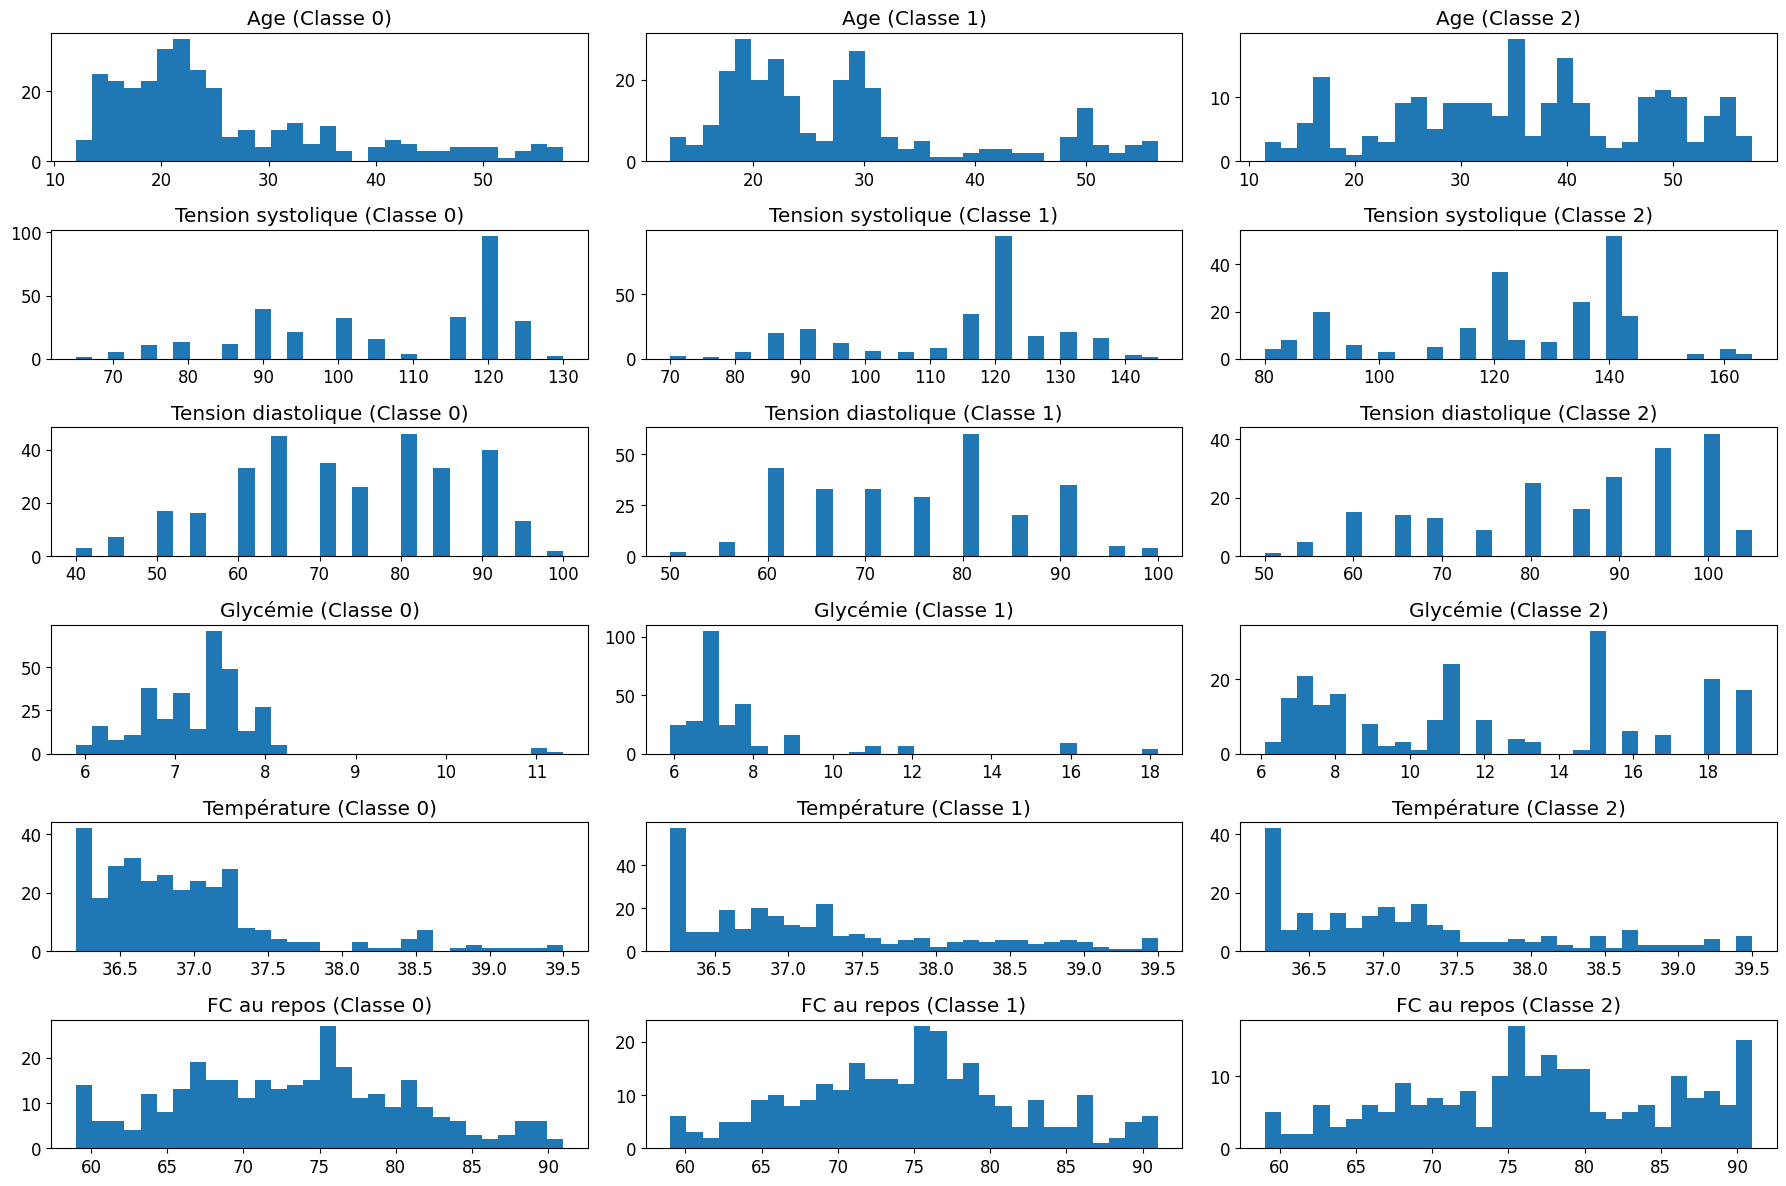

In [18]:
#Pas besoin d'avoir un index des features car tout est continu, on peut donc juste itérer sur les plot_idx
#On utilise un masque sur le dataframe afin de séparer les différentes classes, on utilise donc pas directement le X_train


fig = plt.figure(figsize=(18, 12))

features = df_train.drop('Risque', axis=1).columns.to_list()

for plot_idx in range(len(features)):

    # 1ère classe : Risque = 0

    ax = fig.add_subplot(6, 3, (3*plot_idx+1)) # créer une sous-figure (subplot) à la position (3*plot_idx+1) d'une grille 6x3
    h = ax.hist(np.array(df_train[df_train['Risque']==0])[:, plot_idx], bins=30, edgecolor='none')  #On réalise le masque
    ax.set_title("%s (Classe 0)" % features[plot_idx])    
    

    #2ème classe

    ax = fig.add_subplot(6, 3, (3*plot_idx+2))
    h = ax.hist(np.array(df_train[df_train['Risque']==1])[:, plot_idx], bins=30, edgecolor='none')
    ax.set_title("%s (Classe 1)" % features[plot_idx])

   
    #3ème classe

    ax = fig.add_subplot(6,3, (3*plot_idx+3))
    h = ax.hist(np.array(df_train[df_train['Risque']==2])[:, plot_idx], bins=30, edgecolor='none')
    ax.set_title("%s (Classe 2)" % features[plot_idx])

    
# espacement entre les subplots
fig.tight_layout(pad=1.0)

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

Elles ne sont pas surprenantes, elles sont cohérentes avec les moyennes usuelles. On note qu'il y a clairement une cohérence avec le degré de risque, en effet on voit qu'une augmentation du risque est liée avec l'augmentation de l'âge , de la tension, de la glycémie, etc ..

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

Utiliser 6 variables pour de la prédiction est faisable mais demandant en calcul, on pourrait commencer à réaliser une PCA afin de réduire la dimension.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

In [19]:
from sklearn import decomposition
from sklearn import preprocessing

On va désormais standardiser nos données afin de réaliser la PCA

In [123]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)
X_scaled

array([[-0.69916543, -1.52474273, -1.5546662 , -0.53061214, -1.09321117,
         1.19463577],
       [ 0.5600249 ,  1.69867286,  1.665586  , -0.5612878 ,  3.00982763,
        -0.20837968],
       [-1.16086855,  0.35558303, -0.123443  , -0.40790952,  2.38815508,
        -0.08083282],
       ...,
       [ 2.02908028, -0.71888883, -0.4812488 , -0.31588256, -1.09321117,
        -0.84611398],
       [-0.90903049,  0.35558303, -0.4812488 , -0.37723387,  0.02579941,
        -0.71856712],
       [-0.65719242, -0.71888883,  0.9499744 , -0.59196345,  0.27446843,
        -1.10120769]])

In [124]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

On peut projeter sur les deux dimensions :

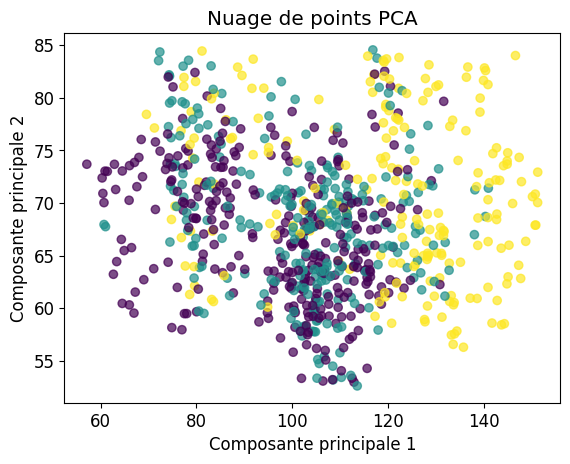

In [125]:
X_projected=pca.transform(X_train) #On peut visualiser les 3 classes
labels=df_train['Risque']
plt.scatter(X_projected[:,0], X_projected[:,1], c=labels, alpha=0.7)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Nuage de points PCA")
plt.show()

In [122]:
X_projected

array([[ 74.17216439,  77.25628684],
       [135.03395818,  64.36766305],
       [ 99.89330376,  65.86921291],
       ...,
       [105.67614642,  67.93375643],
       [ 99.39649218,  62.05279968],
       [100.28956099,  59.67969922]])

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

On peut regarder la variance expliquée pour savoir :

In [116]:
print(pca.explained_variance_ratio_)

[0.43311432 0.19646383 0.1359057  0.1129674  0.07713432 0.04441443]


On voit qu'on explique 80% de la variance avec deux variables et 90% avec 3 variables, donc un modèle avec 3 variables serait un meilleur compromis.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

On va importer seaborn pour visualiser la matrice de corrélation

In [24]:
import seaborn as sns

Text(0.5, 1.0, 'Corrélation entre les variables')

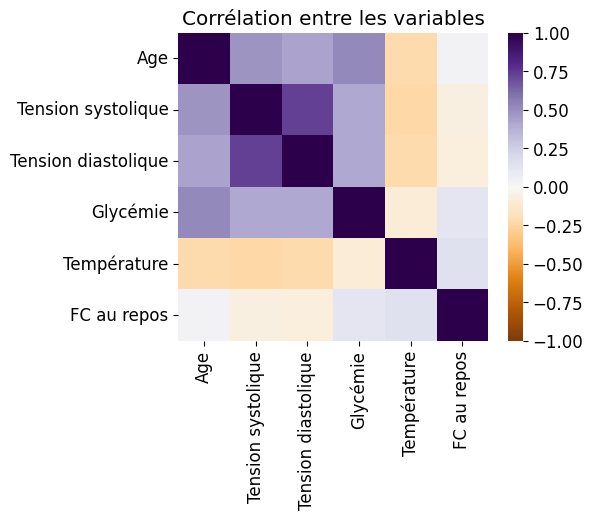

In [25]:
# Calcul de la matrice de corrélation deux à deux
corr_matrix = df_train.drop(columns=['Risque']).corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
# Titre
plt.title("Corrélation entre les variables")

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

On peut observer quelles variables sont très corrélées entre elles pour en éliminer certaines, par exemple les deux tensions sont très liées, on peut considérer l'option d'enlever une de ses variables pour réduire la dimension;

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [26]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

In [27]:
df_train_risk_vs_norisk.head()

Age  Tension systolique  Tension diastolique  Glycémie  Température  \
0  21.0                85.0                 55.0       7.0         36.2   
1  36.0               145.0                100.0       6.9         39.5   
2  15.5               120.0                 75.0       7.4         39.0   
3  49.0               135.0                100.0      15.9         37.8   
4  56.5               120.0                 90.0      12.0         36.9   

   FC au repos  Risque  
0         84.0       1  
1         73.0       1  
2         74.0       0  
3         72.0       1  
4         74.0       1

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

L'accuracy serait alors la proportion de la classe majoritaire. Il suffirait alors de voir quelle classe est majoritraire puis de diviser le nombre d'individu par le nombre total d'observation.

### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

La BA est la moyenne de la précision et de la sensibilité. On peut donc prendre en compte les deux erreurs concernant le positif : les faux positifs et les faux négatifs.

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

Durant l'entrainement on va uniquement stocker les données, on estime pas de paramètres.

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

Pour le jeu d'entraînement on aura une précsion de 100% car le voisin le plus proche sera l'observation elle-même puisque l'observation fera déjà partie des données stockées durant l'entraînement.

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [28]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1) #1 va suffire 

In [29]:
neigh.fit(X_train, y_train)
accuracy = neigh.score(X_train, y_train)
print("Accuracy:", accuracy)

Accuracy: 1.0


On a bien 100% d'accuracy

### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

Il faut utiliser les données centrées-réduites pour que toutes les variables aient un poids similaire dans la recherche des plus proches voisins.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [92]:
# instantier un objet KFold 
from sklearn import model_selection
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=32) #On va faire 10 folds


In [93]:
# Définir la grille de valeurs de l'hyperparamètre alpha 
k = np.arange(1, 100)

# Définir le modèle à évaluer
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()

# Instantier la recherche sur grille
grid_neigh = model_selection.GridSearchCV(neigh, {'n_neighbors': k},
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid_neigh.fit(X_scaled, y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=32, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             scoring='balanced_accuracy')

In [94]:
grid_neigh.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

<Figure size 800x400 with 0 Axes>

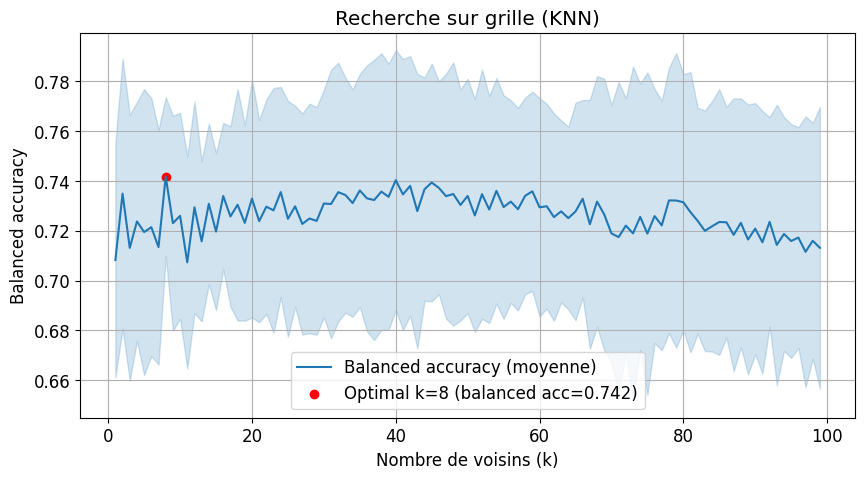

In [96]:
plt.figure(figsize=(8, 4))

mean_balanced_acc = grid_neigh.cv_results_['mean_test_score']
std_balanced_acc = grid_neigh.cv_results_['std_test_score']
best_k = grid_neigh.best_params_['n_neighbors']
best_score = grid_neigh.best_score_

plt.figure(figsize=(10, 5))
plt.plot(k, mean_balanced_acc, label="Balanced accuracy (moyenne)", color='tab:blue')
plt.fill_between(
    k,
    mean_balanced_acc - std_balanced_acc,
    mean_balanced_acc + std_balanced_acc,
    color='tab:blue',
    alpha=0.2
)
plt.scatter(
    [best_k],
    [best_score],
    color='red',
    label=f"Optimal k={best_k} (balanced acc={best_score:.3f})"
)

plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Balanced accuracy")
plt.title("Recherche sur grille (KNN)")
plt.legend()
plt.grid(True)
plt.show()

In [88]:
print(grid_neigh.best_params_['n_neighbors'], ' & ',grid_neigh.best_score_)

8  &  0.7417656617992996


## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [97]:
# instantier un objet KFold 
from sklearn import model_selection
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=32) #On va faire 10 folds
 
C = np.logspace(-5, 3, 60)

# Définir le modèle à évaluer
from sklearn import linear_model
logreg = linear_model.LogisticRegression()

# Instantier la recherche sur grille
grid_logreg = model_selection.GridSearchCV(logreg, {'C': C},
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid_logreg.fit(X_scaled, y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=32, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-05, 1.36644835e-05, 1.86718109e-05, 2.55140652e-05,
       3.48636523e-05, 4.76393801e-05, 6.50967523e-05, 8.89513497e-05,
       1.21547425e-04, 1.66088278e-04, 2.26951054e-04, 3.10116893e-04,
       4.23758716e-04, 5.79044398e-04, 7.91234262e-04, 1.08118...
       7.60949669e-01, 1.03979842e+00, 1.42083083e+00, 1.94149195e+00,
       2.65294846e+00, 3.62511705e+00, 4.95353521e+00, 6.76875001e+00,
       9.24914728e+00, 1.26384820e+01, 1.72698329e+01, 2.35983347e+01,
       3.22459055e+01, 4.40623643e+01, 6.02089449e+01, 8.22724134e+01,
       1.12421004e+02, 1.53617495e+02, 2.09910372e+02, 2.86831681e+02,
       3.91940677e+02, 5.35566692e+02, 7.31824222e+02, 1.00000000e+03])},
             scoring='balanced_accuracy')

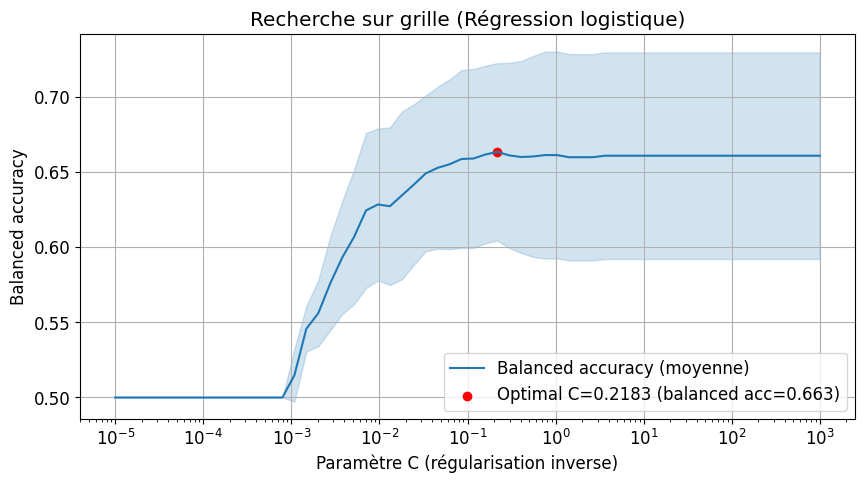

In [100]:
plt.figure(figsize=(10, 5))

Cs = grid_logreg.param_grid['C']  # Ton vecteur de valeurs C

mean_balanced_acc = grid_logreg.cv_results_['mean_test_score']
std_balanced_acc = grid_logreg.cv_results_['std_test_score']
best_C = grid_logreg.best_params_['C']
best_score = grid_logreg.best_score_

plt.semilogx(Cs, mean_balanced_acc, label="Balanced accuracy (moyenne)", color='tab:blue')
plt.fill_between(
    Cs,
    mean_balanced_acc - std_balanced_acc,
    mean_balanced_acc + std_balanced_acc,
    color='tab:blue',
    alpha=0.2
)
plt.scatter(
    [best_C],
    [best_score],
    color='red',
    label=f"Optimal C={best_C:.4f} (balanced acc={best_score:.3f})"
)

plt.xlabel("Paramètre C (régularisation inverse)")
plt.ylabel("Balanced accuracy")
plt.title("Recherche sur grille (Régression logistique)")
plt.legend()
plt.grid(True)
plt.show()


## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

On a décidé de faire avec l'algorithme de la random forest car on le trouvait intéressant

In [111]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

rand_forest = RandomForestClassifier(random_state=42)

# Grille des hyperparamètres
param_grid = {
    'n_estimators': [10, 50, 100, 150, 200, 300],
    'max_depth': [3, 5, 7, 10, 15, 20, 30]
}

# Recherche sur grille
grid_rf = model_selection.GridSearchCV(
    rand_forest,
    param_grid,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# Entraînement
grid_rf.fit(X_scaled, y_train_risk_vs_norisk)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15, 20, 30],
                         'n_estimators': [10, 50, 100, 150, 200, 300]},
             scoring='balanced_accuracy')

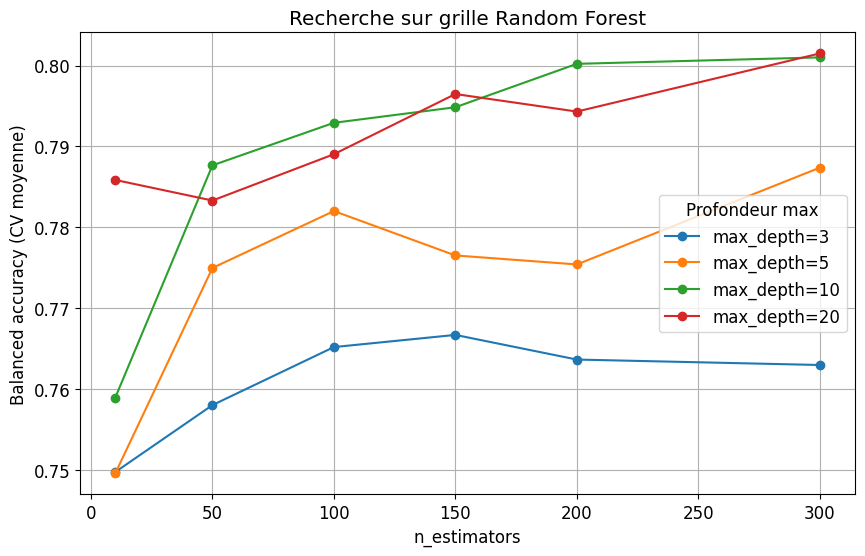

In [112]:
import matplotlib.pyplot as plt
import pandas as pd

# Extraire les résultats
results_df = pd.DataFrame(grid_rf.cv_results_)

plt.figure(figsize=(10,6))

for depth in [3, 5, 10, 20]:
    mask = results_df['param_max_depth'] == depth
    plt.plot(
        results_df.loc[mask, 'param_n_estimators'],
        results_df.loc[mask, 'mean_test_score'],
        marker='o',
        label=f"max_depth={depth}"
    )

plt.xlabel("n_estimators")
plt.ylabel("Balanced accuracy (CV moyenne)")
plt.title("Recherche sur grille Random Forest")
plt.legend(title="Profondeur max")
plt.grid(True)
plt.show()

In [113]:
print("Meilleurs hyperparamètres:", grid_rf.best_params_)
print("Balanced accuracy optimale:", grid_rf.best_score_)

Meilleurs hyperparamètres: {'max_depth': 20, 'n_estimators': 300}
Balanced accuracy optimale: 0.801491738389144


## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

On a eu le meilleur résultat avec l'algorithme de la random forest

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

In [126]:
X_projected

array([[ 74.17216439,  77.25628684],
       [135.03395818,  64.36766305],
       [ 99.89330376,  65.86921291],
       ...,
       [105.67614642,  67.93375643],
       [ 99.39649218,  62.05279968],
       [100.28956099,  59.67969922]])

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

In [127]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

rand_forest = RandomForestClassifier(random_state=42)

# Grille des hyperparamètres
param_grid = {
    'n_estimators': [10, 50, 100, 150, 200, 300],
    'max_depth': [3, 5, 7, 10, 15, 20, 30]
}

# Recherche sur grille
grid_rf = model_selection.GridSearchCV(
    rand_forest,
    param_grid,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# Entraînement
grid_rf.fit(X_projected, y_train_risk_vs_norisk)


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15, 20, 30],
                         'n_estimators': [10, 50, 100, 150, 200, 300]},
             scoring='balanced_accuracy')

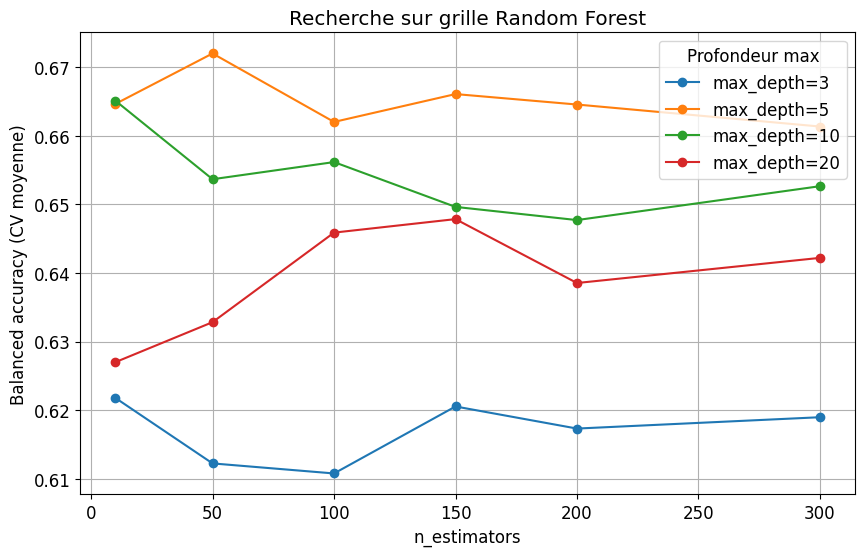

In [129]:
import matplotlib.pyplot as plt
import pandas as pd

# Extraire les résultats
results_df = pd.DataFrame(grid_rf.cv_results_)

plt.figure(figsize=(10,6))

for depth in [3, 5, 10, 20]:
    mask = results_df['param_max_depth'] == depth
    plt.plot(
        results_df.loc[mask, 'param_n_estimators'],
        results_df.loc[mask, 'mean_test_score'],
        marker='o',
        label=f"max_depth={depth}"
    )

plt.xlabel("n_estimators")
plt.ylabel("Balanced accuracy (CV moyenne)")
plt.title("Recherche sur grille Random Forest")
plt.legend(title="Profondeur max")
plt.grid(True)
plt.show()

In [130]:
print("Meilleurs hyperparamètres:", grid_rf.best_params_)
print("Balanced accuracy optimale:", grid_rf.best_score_)

Meilleurs hyperparamètres: {'max_depth': 5, 'n_estimators': 50}
Balanced accuracy optimale: 0.6719955919779033


### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

On a perdu de l'accuracy

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

Le meilleur est la random forest avec le jeu juste scaled mais non transformé par pca, et avec : 'max_depth': 20, 'n_estimators': 300

In [ ]:
final_binary_classifier=RandomForestClassifier(random_state=42,max_depth= 20, n_estimators= 300)
final_binary_classifier.fit(X_scaled, y_train_risk_vs_norisk)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

In [138]:
df_test=pd.read_csv('data/donnees_reservees.csv')
X_test = np.array(df_test.drop('Risque', axis=1))
y_test = np.array(df_test['Risque'], dtype='int')

#On repète les mêmes étpaes qu'avant

# Copier le dataframe initial dans un nouveau dataframe 
df_test_risk_vs_norisk = df_test.copy()

# Regrouper les étiquettes 1 et 2
df_test_risk_vs_norisk['Risque'] = np.where(df_test['Risque']==2, 1, df_test['Risque'])

# Extraction de l'array d'étiquettes
y_test_risk_vs_norisk = np.array(df_test_risk_vs_norisk['Risque'], dtype='int')

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

In [143]:
X_test_scaled=std_scale.transform(X_test)
y_pred=final_binary_classifier.predict(X_test_scaled)

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

In [144]:
from sklearn.metrics import balanced_accuracy_score

score = balanced_accuracy_score(y_test_risk_vs_norisk, y_pred)
print("Accuracy", score)


Accuracy 0.8557745441149383


### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

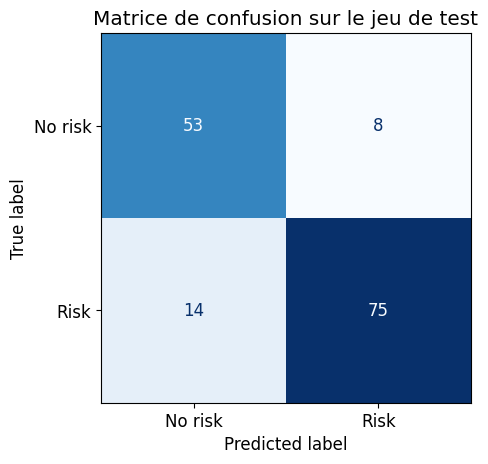

In [145]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(
    y_test_risk_vs_norisk,
    y_pred,
    display_labels=["No risk", "Risk"],
    cmap="Blues",
    colorbar=False
)
plt.title("Matrice de confusion sur le jeu de test")
plt.show()

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

On voit le pourcentage de nombres de vrais positifs et négatifs qui sont significatifs

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.